In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
unzip bank+marketing.zip 
unzip bank.zip

--2024-10-23 13:20:06--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip’

bank+marketing.zip      [     <=>            ] 999.85K   926KB/s    in 1.1s    

2024-10-23 13:20:09 (926 KB/s) - ‘bank+marketing.zip’ saved [1023843]



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no


(45211, 17)

In [84]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('bank-full.csv', sep=';')
df.head(1)
df.shape

lst_ft = [
    'age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 
    'campaign', 'pdays', 'previous', 'poutcome', 'y'
]

df = df[lst_ft].assign(y=lambda df: df.y.eq('yes').astype(int))
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no


(45211, 17)

In [86]:
from sklearn.metrics import roc_auc_score

lst_num_ft = df_train.select_dtypes(include='number').columns
lst_df = []
for ft in lst_num_ft:
    auc = roc_auc_score(y_train, df_train[ft])
    if auc < 0.5:
        auc = 1-auc
    lst_df.append([ft, auc])
pd.DataFrame(lst_df, columns=['feature', 'auc']).sort_values('auc', ascending=False)

,feature,auc
3,duration,0.814700
6,previous,0.598565
5,pdays,0.590128
1,balance,0.588831
4,campaign,0.571454
2,day,0.525958
0,age,0.512186


In [87]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [88]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.9004159581551736)

In [109]:
pos = y_val == 1
neg = y_val == 0
thresholds = np.linspace(0, 1, 101)
lst_df = []

for t in thresholds:
    pred_pos = y_pred >= t
    pred_neg = y_pred < t

    tp = (pred_pos & pos).sum()
    tn = (pred_neg & neg).sum()
    fp = (pred_pos & neg).sum()
    fn = (pred_neg & pos).sum()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    lst_df.append([t, precision, recall, 2*precision*recall / (precision+recall)])

df_perf = pd.DataFrame(lst_df, columns=['t', 'precision', 'recall', 'f1'])
df_perf

/tmp/ipykernel_2535/3194885040.py:14: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


,t,precision,recall,f1
0,0.00,0.121433,1.000000,0.216568
1,0.01,0.135095,0.996357,0.237930
2,0.02,0.158820,0.995446,0.273935
3,0.03,0.186385,0.989982,0.313709
4,0.04,0.219392,0.972678,0.358029
...,...,...,...,...
96,0.96,0.638298,0.027322,0.052402
97,0.97,0.625000,0.022769,0.043937
98,0.98,0.677419,0.019126,0.037201
99,0.99,0.687500,0.010018,0.019749


Text(0.5, 0, 'threshold')

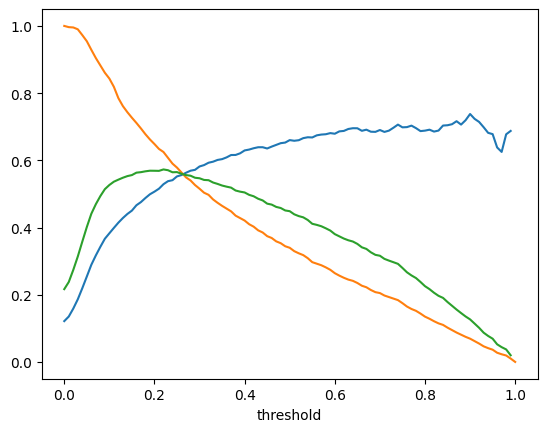

In [110]:
plt.plot(thresholds, df_perf.precision)
plt.plot(thresholds, df_perf.recall)
plt.plot(thresholds, df_perf.f1)
plt.xlabel('threshold')

In [112]:
df_perf.iloc[df_perf.f1.idxmax()]

t            0.220000
precision    0.528913
recall       0.624772
f1           0.572860
Name: 22, dtype: float64